In [1]:
import itertools
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score

# Arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Gráficos FAC e FACP
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Teste de Dickey-Fuller para estacionaridade
from statsmodels.tsa.stattools import adfuller

In [3]:
sm.__version__

'0.11.1'

In [4]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
seaborn.set
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [8]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
ano_inicial = 2015
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
dados_csv.head()

,cotacaoVenda,dataHoraCotacao,tipoBoletim
0,"1,735",2010-01-04 09:23:00.0,Abertura
1,"1,73",2010-01-04 09:30:00.0,Intermediário
2,"1,729",2010-01-04 10:00:00.0,Intermediário
3,"1,73",2010-01-04 10:30:00.0,Intermediário
4,"1,73",2010-01-04 11:00:00.0,Intermediário


In [9]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
dados_brutos.tail()

,cotacaoVenda,dataHoraCotacao
2687,"5,2984",2020-09-14 13:11:26.344
2688,"5,2728",2020-09-15 13:05:23.52
2689,"5,2532",2020-09-16 13:07:28.885
2690,"5,2593",2020-09-17 13:08:53.951
2691,"5,2889",2020-09-18 13:07:46.211


In [11]:
# Renomear e tratar as colunas para os formatos do fbprophet
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
dados = dados["2015-01-01":]
dados.head()

,cotacao
dia,
2015-01-02,2.6929
2015-01-05,2.7107
2015-01-06,2.7023
2015-01-07,2.6807
2015-01-08,2.6919


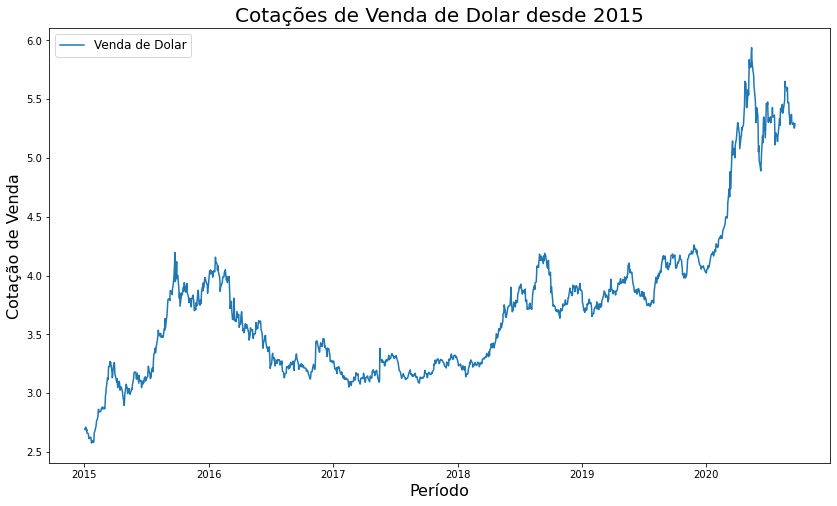

In [12]:
# filtrando janelas de tempo
#dados_pos = dados.loc[datetime.strptime("20200401", ""):,:]

# Exibindo série original
plt.plot(dados, label="Venda de %s"%moeda)
plt.title("Cotações de Venda de %s desde %d"%(moeda, ano_inicial), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda", fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Verificar necessidade da transformação Box-Cox

MSE: 0.018
R2:  0.377


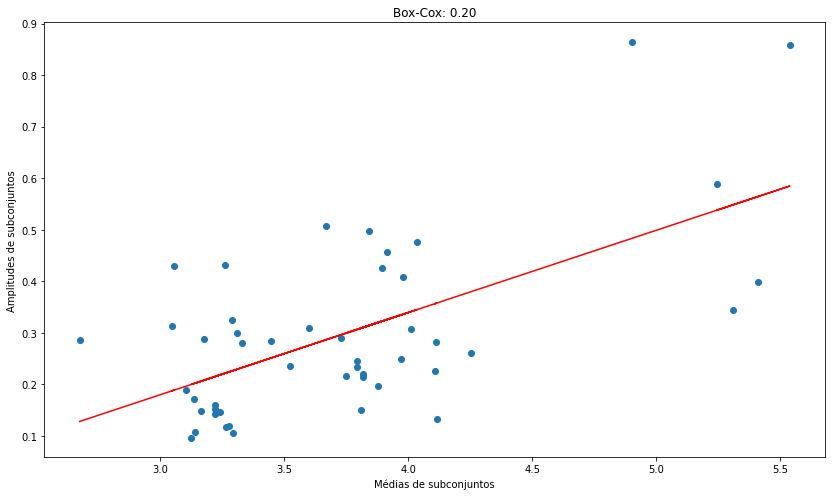

In [13]:
k = 30
blocos = dados.shape[0]//k

med, amp = [], []
for i in range(blocos+1):
    med.append(dados.cotacao[k*i:k*(i+1)].mean())
    amp.append(dados.cotacao[k*i:k*(i+1)].max() - dados.cotacao[k*i:k*(i+1)].min())

med = np.array(med).reshape(-1, 1)
amp = np.array(amp)

regr = LinearRegression()
regr.fit(med, amp)
amp_pred = regr.predict(med)
print("MSE: %.3f"%mse(amp, amp_pred))
print("R2:  %.3f"%r2_score(amp, amp_pred))

plt.scatter(med, amp)
plt.plot(med, amp_pred, color="r")
plt.gca().update(dict(xlabel='Médias de subconjuntos', ylabel='Amplitudes de subconjuntos'))
plt.title("Box-Cox: %.2f"%(np.arctan(regr.coef_)*180/np.pi/45))
plt.show()

In [14]:
# Aplicando transformação box-cox
lamb = 0.15
dados["box"] = (dados.cotacao**lamb - 1)/lamb
#dados["box"] = np.log(dados.cotacao)
dados.head()

,cotacao,box
dia,,
2015-01-02,2.6929,1.068003
2015-01-05,2.7107,1.075651
2015-01-06,2.7023,1.072047
2015-01-07,2.6807,1.062737
2015-01-08,2.6919,1.067572


In [15]:
# função de anti-transformação
def antibox(x):
    return (x*lamb + 1)**(1/lamb)

### Função de autocorrelação

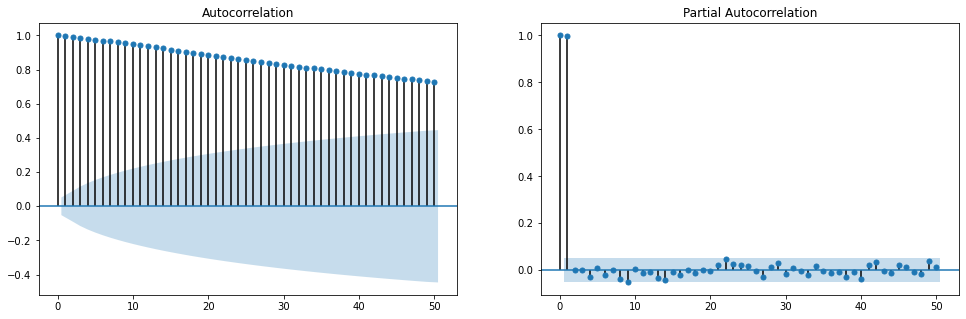

In [16]:
# Autocorrelação
def plotar_autocorrelacao(campo, lags=50):
    '''(np.array, int) -> None'''
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
    acf = plot_acf(campo, lags=lags, ax=ax[0])
    pacf = plot_pacf(campo, lags=lags, ax=ax[1])
    plt.show()
    
#plotar_autocorrelacao(dados.cotacao)
plotar_autocorrelacao(dados.box)

## Estacionaridade
Na maioria dos testes de estacionaridade a hipótese nula é de que a série tenha raiz unitária, e portanto não seja estacionária, logo:

    H0: tem raiz unitária (não é estacionária)
    H1: não tem raiz unitária (é estacionária)

In [17]:
def teste_adfuller(campo):
    '''(str) -> None'''
    adfuller_test = adfuller(campo.dropna())
    print("P-valor do teste de Dickey-Fuller para a série: %.3f"%(adfuller_test[0]))
    if adfuller_test[0] < 0.05:
        print("Não vale H0 -> Série estacionária")
    else:
        print("Vale H0 -> Série não-estacionária")

teste_adfuller(dados.box)

P-valor do teste de Dickey-Fuller para a série: -0.792
Não vale H0 -> Série estacionária


### Diferenciação
Consiste em tomar sucessivas diferenças da série original até encontrar uma série estacionária:

  1. Primeira ordem: $ y_t = x_t - x_{t-1} = \nabla x_t $
  2. Segunda ordem:  $ y_t = \nabla^2 x_t = \nabla(x_t - x_{t-1}) = x_t - 2x_{t-1} + x_{t-2} $

In [12]:
#dados.drop("cotacao_diff", axis=1, inplace=True)
#dados["cotacao_diff"] = dados["cotacao"].diff()
#dados.cotacao_diff.tail()

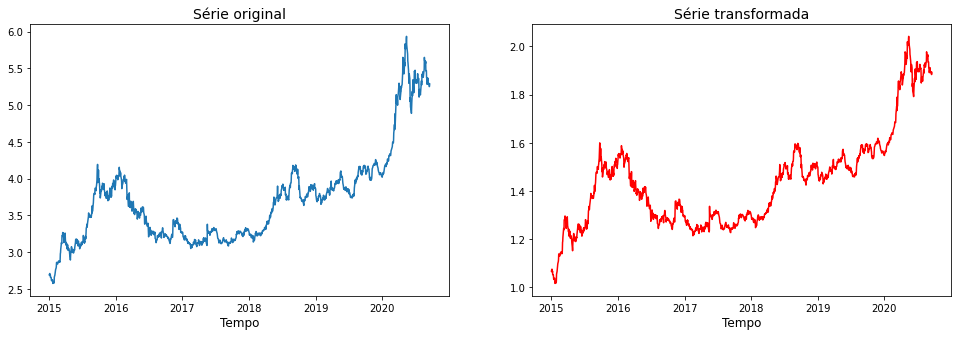

In [18]:
# série original
fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
ax[0].plot(dados.cotacao)
ax[0].set_title("Série original", fontsize=14)
ax[0].set_xlabel("Tempo", fontsize=12)

# série transformada
ax[1].plot(dados.box, color="red")
ax[1].set_title("Série transformada", fontsize=14)
ax[1].set_xlabel("Tempo", fontsize=12)
plt.show()

# série diferenciada
#ax[1].plot(dados.cotacao_diff, color="red")
#ax[1].set_title("Série diferenciada", fontsize=14)
#ax[1].set_xlabel("Tempo", fontsize=12)
#plt.show()

## Treinamento
Treinar respeitando a ordenação temporal

    Validação: Treino | Teste |
    Previsão:  Treino         | Previsão

In [19]:
train_size = 0.90
train = dados.reset_index().loc[:np.round(dados.shape[0]*train_size), :]
test = dados.reset_index().loc[train.index.max()+1:, :]
train = train.set_index("dia")
test = test.set_index("dia")
# conferindo
print(train.index.max().date(), test.index.min().date())

2020-02-26 2020-02-27


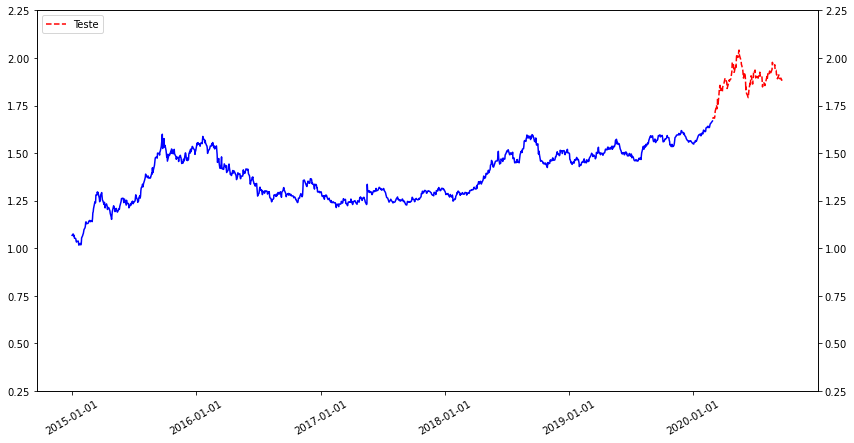

In [20]:
def plotar_serie(train_x, train_y, test_x, test_y, label="", ymin=0.25, ymax=2.25):
    seaborn.set_style({"axes.grid": False})
    fig, ax = plt.subplots(figsize=(14,7))
    ax.plot(train_x, train_y, "b-", label="Dados de treino")
    ax.set_ylim(ymin, ymax)
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    ax2 = ax.twinx()
    ax2.plot(test_x, test_y, "r--", label=label)
    ax2.set_ylim(ymin, ymax)
    ax2.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    plt.legend(loc=2)
    plt.show()
    
plotar_serie(train.index, train.box, test.index, test.box, "Teste")

## Parâmetros do modelo

    *p é a ordem do componente autoregressiva
    *d é o número de diferenças tomadas na série
    *q é a ordem da componente de médias móveis

In [21]:
p = q = range(0, 2)
d = [0]
pdq = list(itertools.product(p, d, q))[1:] # ignorando (0, 0, 0)
print(pdq)

[(0, 0, 1), (1, 0, 0), (1, 0, 1)]


In [22]:
# construindo uma busca de parâmetros ótimos
best_params = None
best_aic = float("inf")
best_model = None

for param in tqdm(pdq):
    try:
        #mod = sm.tsa.ARMA(train.box, order=param)
        mod = ARIMA(train.box, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = mod
        print("ARIMA%s - AIC:%f"%(param, results.aic))
    except:
        continue

# Exibindo qual o melhor modelo encontrado
print("ARIMA%s - AIC:%f"%(best_params, best_aic))

ARIMA(0, 0, 1) - AIC:-3147.726896
ARIMA(1, 0, 0) - AIC:-7893.466919
ARIMA(1, 0, 1) - AIC:-7892.009756

ARIMA(1, 0, 0) - AIC:-7893.466919


In [23]:
# fixando resultados
#best_model = sm.tsa.ARMA(train.box, order=best_params)
best_model = ARIMA(train.box, order=(1, 0, 0))
modelo_treinado = best_model.fit()

# exibe estatísticas da predição
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    box   No. Observations:                 1291
Model:                     ARMA(1, 0)   Log Likelihood                3949.733
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 27 Nov 2020   AIC                          -7893.467
Time:                        16:49:44   BIC                          -7877.977
Sample:                             0   HQIC                         -7887.653
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3778      0.148      9.339      0.000       1.089       1.667
ar.L1.box      0.9985      0.002    634.346      0.000       0.995       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

MSE:  3.6102111355858864e-07


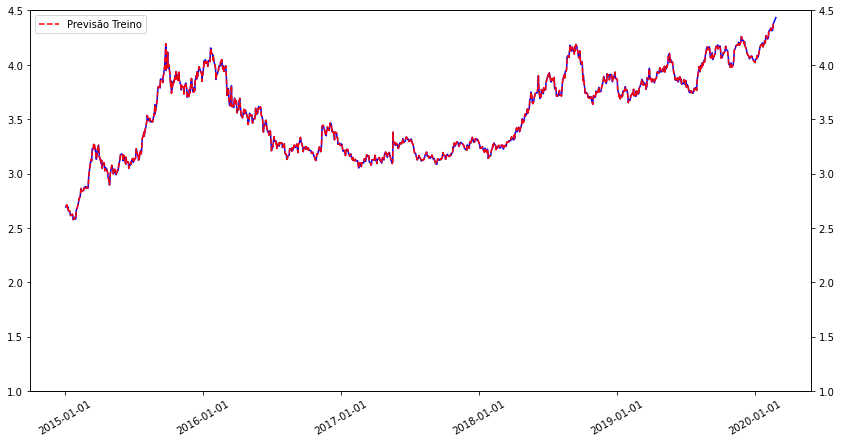

In [24]:
# Previsão no conjunto de treino
train_pred = modelo_treinado.predict(start=train.index.min().date())
train_pred = (train_pred*lamb + 1)**(1/lamb)

print("MSE: ", mse(train.cotacao[:-1], train_pred[1:]))
plotar_serie(train.index, train.cotacao, train.index[:-1], train_pred[1:], "Previsão Treino", 1.0, 4.5)

In [32]:
modelo_treinado.forecast(steps=7)

(array([1.66886344, 1.66842689, 1.667991  , 1.66755575, 1.66712117,
        1.66668723, 1.66625394]),
 array([0.01132632, 0.01600583, 0.01958837, 0.02260176, 0.02525062,
        0.02763997, 0.02983225]),
 array([[1.64666426, 1.69106262],
        [1.63705604, 1.69979774],
        [1.6295985 , 1.70638349],
        [1.62325712, 1.71185438],
        [1.61763087, 1.71661146],
        [1.61251389, 1.72086057],
        [1.60778381, 1.72472408]]))

MSE: 0.8211449137826802


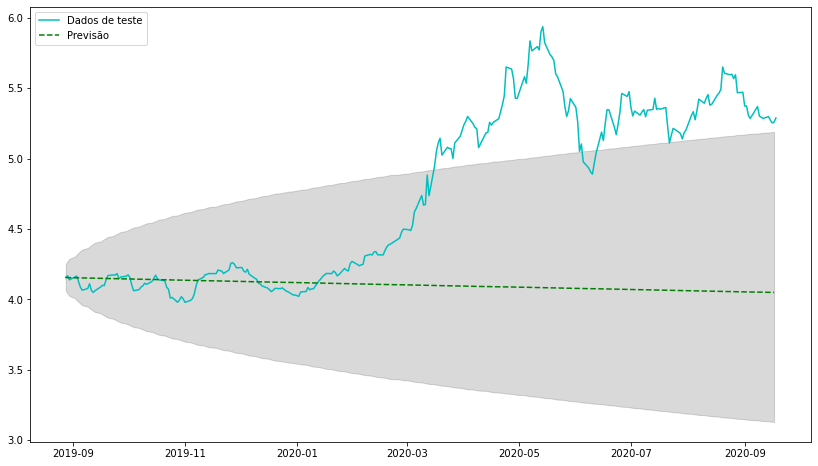

In [123]:
pred_uc = modelo_treinado.forecast(steps=30)

test_pred = antibox(pred_uc[0])
pred_min = [antibox(x[0]) for x in pred_uc[2]]
pred_max = [antibox(x[1]) for x in pred_uc[2]]
print("MSE:", mse(test.cotacao, test_pred))

plt.plot(test.cotacao, "c-", label='Dados de teste')
plt.plot(test.index[:-1], test_pred[1:], "g--", label='Previsão')
plt.fill_between(test.index[:-1],
                 pred_min[1:],
                 pred_max[1:], color='k', alpha=.15)
plt.legend(loc=2)
plt.show()